In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Airline Passengers Dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)

# Check the size of the dataset before scaling
print("Number of rows in the raw dataset:", len(data))

# Take only the "Passengers" column for simplicity
stock_data = data[['Passengers']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Check the size of the dataset after scaling
print("Number of rows in the scaled dataset:", len(scaled_data))

# 21BCE2067 Kshitiz Bhargava

Number of rows in the raw dataset: 144
Number of rows in the scaled dataset: 144


Epoch 1/100


/Users/manvendrasingh/Library/CloudStorage/OneDrive-vit.ac.in/7th Sem/Deep Learning/Lab/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0897 - val_loss: 0.2683
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0744 - val_loss: 0.2200
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0619 - val_loss: 0.1759
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0458 - val_loss: 0.1365
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0349 - val_loss: 0.1024
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0209 - val_loss: 0.0740
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0229 - val_loss: 0.0510
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - val_loss: 0.0347
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - val_loss: 0.0245
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - val_loss: 0.0196
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - val_loss: 0.0183
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - val_loss: 0.0186


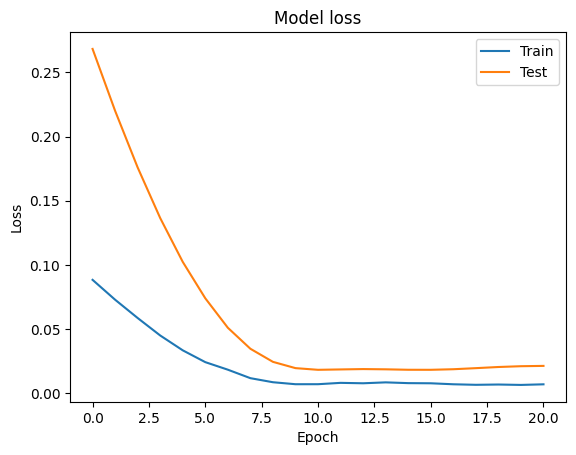

MAPE (Mean Absolute Percentage Error): 13.71%


In [2]:
# Define the create_sequences function
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    if len(data) <= sequence_length:
        return np.array(sequences), np.array(labels)

    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i, 0])
        labels.append(data[i, 0])

    return np.array(sequences), np.array(labels)

# Adjust the sequence length
sequence_length = 24  # Use last 24 months for prediction (2 years)
X, y = create_sequences(scaled_data, sequence_length)

# Reshape for LSTM input
if X.size > 0 and y.size > 0:
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Build the BiLSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))),
        tf.keras.layers.Dropout(0.3),  # Regularization with dropout
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Use lower learning rate for stability
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train)
    test_loss = model.evaluate(X_test, y_test)

    print(f'Training Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')

    # Generate predictions
    y_pred = model.predict(X_test)

    # Inverse scaling
    y_test_inverse = scaler.inverse_transform([y_test])
    y_pred_inverse = scaler.inverse_transform(y_pred)

    # Plot training & validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100
    print(f'MAPE (Mean Absolute Percentage Error): {mape:.2f}%')
else:
    print("Not enough data to create sequences. Adjust sequence_length or add more data.")

# 21BCE2067 Kshitiz Bhargava